In [ ]:
pip install torch

In [ ]:
pip install torchdiffeq

In [53]:
import autograd.numpy as np
from autograd import grad, jacobian
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
#import torch
#from torchdiffeq import odeint

In [119]:


# Define HH model parameters
g_Na = 120.0  # Sodium conductance (mS/cm^2)
g_K = 36.0   # Potassium conductance (mS/cm^2)
g_L = 0.3    # Leak conductance (mS/cm^2)
E_Na = 50.0  # Sodium reversal potential (mV)
E_K = -77.0  # Potassium reversal potential (mV)
E_L = -55.0  # Leak reversal potential (mV)
C_m = 1.0    # Membrane capacitance (uF/cm^2)

# Define the HH model equations
def alpha_m(V):
    return 0.1 * (V + 40.0) / (1.0 - np.exp(-(V + 40.0) / 10.0))

def beta_m(V):
    return 4.0 * np.exp(-(V + 65.0) / 18.0)

def alpha_h(V):
    return 0.07 * np.exp(-(V + 65.0) / 20.0)

def beta_h(V):
    return 1.0 / (1.0 + np.exp(-(V + 35.0) / 10.0))

def alpha_n(V):
    return 0.01 * (V + 55.0) / (1.0 - np.exp(-(V + 55.0) / 10.0))

def beta_n(V):
    return 0.125 * np.exp(-(V + 65) / 80.0)

# Define the HH model differential equations
def hodgkin_huxley_eq(V, m, h, n, I_params, t):
    I = I_params[0]*np.sin(I_params[1]*t)
    dVdt = (I - g_Na * m**3 * h * (V - E_Na) - g_K * n**4 * (V - E_K) - g_L * (V - E_L)) / C_m
    dmdt = alpha_m(V) * (1 - m) - beta_m(V) * m
    dhdt = alpha_h(V) * (1 - h) - beta_h(V) * h
    dndt = alpha_n(V) * (1 - n) - beta_n(V) * n
    return dVdt, dmdt, dhdt, dndt

# Define time parameters
dt = 0.01  # Time step (ms)
t = np.arange(0, 50, dt)  # Time vector (ms)

# Define input stimulus waveform (e.g., a step current)
I_stimulus = np.zeros_like(t)
I_stimulus[100:500] = 10.0  # Apply a current step from 100 ms to 500 ms

# Initialize state variables
V0 = -65.0  # Membrane voltage (mV)
m, h, n = 0.05, 0.6, 0.32  # Initial values of gating variables

# Simulate the HH model and record data
V_record = np.zeros_like(t)
V = V0

A = 10.0
w = 0.5

I_params = np.array([A, w])

for time in t:
    V_record[i] = V
    dVdt, dmdt, dhdt, dndt = hodgkin_huxley_eq(V, m, h, n, I_params, time)
    V += dVdt * dt
    m += dmdt * dt
    h += dhdt * dt
    n += dndt * dt

    

In [120]:
def integrate_HH(V0, m, h, n, I_params, dt, t):
    
    V_record = np.zeros_like(t)
    V = V0
    
    for i in range(len(t)):
        V_record[i] = V
        dVdt, dmdt, dhdt, dndt = hodgkin_huxley_eq(V, m, h, n, I_params, t[i])
        V += dVdt * dt
        m += dmdt * dt
        h += dhdt * dt
        n += dndt * dt
    return V_record


    

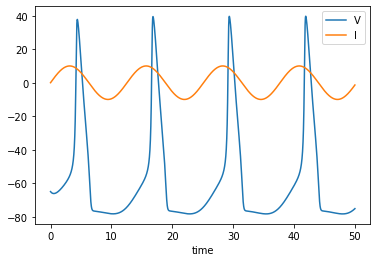

In [121]:
V_record = integrate_HH(V0, m, h, n, I_params, dt, t)

I_stimulus = A*np.sin(w*t)

plt.plot(t, V_record, label = 'V')
plt.plot(t, I_stimulus, label = 'I')
plt.xlabel('time')
plt.legend()

In [6]:


def hodgkin_huxley_neural_ode(t, z, I_stimulus):
    V, m, h, n = z
    dVdt, dmdt, dhdt, dndt = hodgkin_huxley_eq(V, m, h, n, I_stimulus)
    return [dVdt, dmdt, dhdt, dndt]

# Create a function to solve the neural ODE
def solve_neural_ode(I_stimulus, t_span):
    z0 = [-65.0, 0.05, 0.6, 0.32]  # Initial conditions for V, m, h, n
    return odeint(hodgkin_huxley_neural_ode, torch.tensor(z0), t_span, args=(I_stimulus,))


## Adjoint

In [24]:
# #np.load('./sim_data/t_vec.p', allow_pickle = True)
# import pickle

# import neuron.hoc39
# #from neuron import h, gui
# t_file = './sim_data/t_vec.p'


# with open(t_file, mode='rb') as f:
#     t_data = pickle.load(f)


5000

#### Fake Data

In [122]:
# run forward model to create fake data to test adjoint

# Initialize state variables
V = -65.0  # Membrane voltage (mV)
m, h, n = 0.05, 0.6, 0.32  # Initial values of gating variables


V_subsamp = V_record[::10]
    
mean = np.mean(V_subsamp)
stddev = np.std(V_subsamp)

noise = np.random.normal(mean, stddev, len(V_subsamp))
V_data = V_subsamp + noise

data_steps = t[::10]

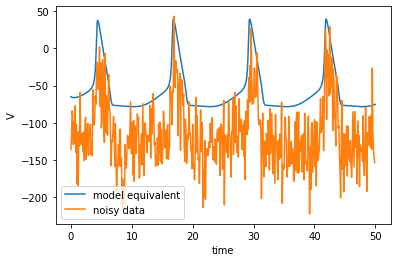

In [123]:
plt.plot(t, V_record, label = 'model equivalent')
plt.plot(data_steps, V_data, label = 'noisy data')
plt.xlabel('time')
plt.ylabel('V')
plt.legend()

#### Compute Gradient

In [127]:
def forward_model_cost(V0, m, h, n, I_params, dt, t, data_steps, V_data):

    cost = 0
        
    V_record = np.zeros_like(t)
    V = V0
    
    for i in range(len(t)):
        
        # run forward step
        V_record[i] = V
        
        #I = A*np.sin(w*t[i])
        #I = I_stimulus[i]
        
        dVdt, dmdt, dhdt, dndt = hodgkin_huxley_eq(V, m, h, n, I_params, t[i])
        V += dVdt * dt
        m += dmdt * dt
        h += dhdt * dt
        n += dndt * dt

        # compute model-data misfit
        if t[i] in data_steps:
            j = np.where(data_steps == t[i])
            cost += (V_record[i] - V_data[j])**2
            
    #return V_record, cost
    return cost


        
        

In [128]:
# Initialize state variables
V0 = -65.0  # Membrane voltage (mV)
m, h, n = 0.05, 0.6, 0.32  # Initial values of gating variables

A = 10
w = 0.5

total_cost = forward_model_cost(V0, m, h, n, I_params, dt, t, data_steps, V_data)

total_cost

array([2294195.79874788])

In [129]:
import autograd.numpy as np
from autograd import grad, jacobian

grad_AD = grad(forward_model_cost, 4) # 4 indicates differentiation w.r.t. the fourth argument of f.
# second argument indicates differentiation wrt to that number argument of the fn to differentiate


In [130]:
# test autograd

grad_AD(V0, m, h, n, I_params, dt, t, data_steps, V_data)
#jac_AD(V, m, h, n, I_stimulus, dt, t, data_steps, V_data)

ValueError: setting an array element with a sequence.

#### FD Check

In [140]:
# FD check wrt I

# I1 = np.random.randint(0,10,5000)
# L1 = forward_model_cost(V, m, h, n, I1, dt, t, data_steps, V_data)

# p = np.random.randint(0,10,5000)
# s = 1e-7 # step size
# I2 = I1 + s*p
# L2 = forward_model_cost(V, m, h, n, I2, dt, t, data_steps, V_data)
# dL_dI_p_diff = (L2[0] - L1[0]) / s

# g = grad_AD(V, m, h, n, I1, dt, t, data_steps, V_data)
# dJ_du_p = np.dot(g, p)

In [44]:
# FD check wrt V

V1 = np.random.uniform(-100,0)
L1 = forward_model_cost(V1, m, h, n, I_stimulus, dt, t, data_steps, V_data)

p = np.random.randint(0,5000)
s = 1e-7 # step size
V2 = V1 + s*p
L2 = forward_model_cost(V2, m, h, n, I_stimulus, dt, t, data_steps, V_data)
dL_dV_p_diff = (L2 - L1) / s

g = grad_AD(V, m, h, n, I_stimulus, dt, t, data_steps, V_data)
dL_dV_p = np.dot(g, p)

grad_err = np.abs( (dL_dV_p - dL_dV_p_diff) / dL_dV_p_diff )
print('step size=', s, ', gradient finite difference error=', grad_err)

step size= 1e-07 , gradient finite difference error= [0.85771049]


/var/folders/6j/fcfm9_6n3rg0rg4_4flv5ks00000gq/T/ipykernel_31894/2811535109.py:32: RuntimeWarning: invalid value encountered in double_scalars
  dmdt = alpha_m(V) * (1 - m) - beta_m(V) * m
/var/folders/6j/fcfm9_6n3rg0rg4_4flv5ks00000gq/T/ipykernel_31894/2811535109.py:33: RuntimeWarning: invalid value encountered in double_scalars
  dhdt = alpha_h(V) * (1 - h) - beta_h(V) * h
/var/folders/6j/fcfm9_6n3rg0rg4_4flv5ks00000gq/T/ipykernel_31894/2811535109.py:34: RuntimeWarning: invalid value encountered in double_scalars
  dndt = alpha_n(V) * (1 - n) - beta_n(V) * n


step size= 1.0 , example gradient finite difference error= [nan]
step size= 0.1 , example gradient finite difference error= [0.05676289]
step size= 0.01 , example gradient finite difference error= [0.04663911]
step size= 0.001 , example gradient finite difference error= [0.10028057]
step size= 0.0001 , example gradient finite difference error= [0.01355666]
step size= 1e-05 , example gradient finite difference error= [0.0014031]
step size= 1e-06 , example gradient finite difference error= [0.0001408]
step size= 1e-07 , example gradient finite difference error= [1.40998444e-05]
step size= 1e-08 , example gradient finite difference error= [1.55319943e-06]
step size= 1e-09 , example gradient finite difference error= [2.90198995e-06]
step size= 1e-10 , example gradient finite difference error= [1.94180874e-05]
step size= 1e-11 , example gradient finite difference error= [0.00022041]
step size= 1e-12 , example gradient finite difference error= [0.00217946]
step size= 1e-13 , example gradient

Text(0, 0.5, 'error')

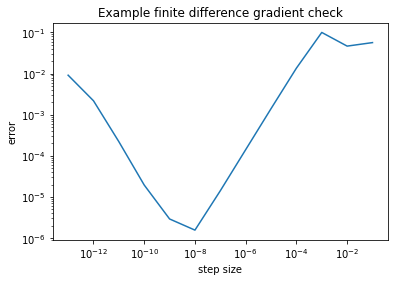

In [45]:
step_sizes = [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13]


# Make log-log plot of gradient finite difference error vs. step size

V1 = np.random.uniform(-100,0)
L1 = forward_model_cost(V1, m, h, n, I_stimulus, dt, t, data_steps, V_data)

# compute gradient using autograd
g = grad_AD(V1, m, h, n, I_stimulus, dt, t, data_steps, V_data)
dL_dV_p = np.dot(g, p)

# j = jac_AD(V1, m, h, n, I_stimulus, dt, t, data_steps, V_data)
# dL_dV_p = np.dot(j, p)


grad_errs = list()
for s in step_sizes:
    
    # compute gradient using finite differences
    V2 = V1 + s*p

    L2 = forward_model_cost(V2, m, h, n, I_stimulus, dt, t, data_steps, V_data)
    dL_dV_p_diff = (L2 - L1) / s


    # compute gradient error
    grad_err = np.abs( (dL_dV_p - dL_dV_p_diff) / dL_dV_p_diff )
    print('step size=', s, ', example gradient finite difference error=', grad_err)
    
    grad_errs.append(grad_err)

plt.loglog(step_sizes, grad_errs)
plt.title('Example finite difference gradient check')
plt.xlabel('step size')
plt.ylabel('error')



#### Steepest Descent

In [46]:
from scipy import optimize

L_func = lambda V: forward_model_cost(V, m, h, n, I_stimulus, dt, t, data_steps, V_data)
g_func = lambda V: grad_AD(V, m, h, n, I_stimulus, dt, t, data_steps, V_data)
#j_func = lambda V: jac_AD(V, m, h, n, I_stimulus, dt, t, data_steps, V_data)

L0 = L_func(V)
g0 = g_func(V)
#j0 = j_func(V)
norm_g0 = np.linalg.norm(g0)
#norm_j0 = np.linalg.norm(j0)

LL_sd = list()
LL_sd.append(L0) # Keep appending the value of J to this list each iteration

gradnorms_sd = list()
gradnorms_sd.append(norm_g0) # keep appending the value of ||g|| each iteration
# jacnorms_sd = list()
# jacnorms_sd.append(norm_j0)


# Solve optimization problem using method of steepest descent. 

Vk = V
norm_gk = norm_g0
#norm_jk = norm_j0

while norm_gk >= 1e-6 * norm_g0:
    bk = optimize.line_search(L_func, g_func, Vk, -g_func(Vk))[0]
    
    Vk = Vk - bk * g_func(Vk)
    g_k = g_func(Vk)
    norm_gk = np.linalg.norm(g_k)
    
    LL_sd.append(L_func(Vk))
    gradnorms_sd.append(norm_gk)

# while norm_jk >= 1e-6 * norm_j0:
#     bk = optimize.line_search(L_func, j_func, Vk, -j_func(Vk))[0]
    
#     Vk = Vk - bk * j_func(Vk)
#     j_k = j_func(Vk)
#     norm_jk = np.linalg.norm(j_k)
    
#     LL_sd.append(L_func(Vk))
#     jacnorms_sd.append(norm_jk)


    
# Now the solution should be in the variable u
# and LL_sd should be a list, with LL[k] = L(V_k)

LL_sd = np.array(LL_sd) # Make JJ_sd into array instead of list
gradnorms_sd = np.array(gradnorms_sd)
#jacnorms_sd = np.array(jacnorms_sd)



/var/folders/6j/fcfm9_6n3rg0rg4_4flv5ks00000gq/T/ipykernel_31894/2811535109.py:31: RuntimeWarning: invalid value encountered in double_scalars
  dVdt = (I - g_Na * m**3 * h * (V - E_Na) - g_K * n**4 * (V - E_K) - g_L * (V - E_L)) / C_m
/var/folders/6j/fcfm9_6n3rg0rg4_4flv5ks00000gq/T/ipykernel_31894/2811535109.py:32: RuntimeWarning: invalid value encountered in double_scalars
  dmdt = alpha_m(V) * (1 - m) - beta_m(V) * m
/var/folders/6j/fcfm9_6n3rg0rg4_4flv5ks00000gq/T/ipykernel_31894/2811535109.py:33: RuntimeWarning: invalid value encountered in double_scalars
  dhdt = alpha_h(V) * (1 - h) - beta_h(V) * h
/var/folders/6j/fcfm9_6n3rg0rg4_4flv5ks00000gq/T/ipykernel_31894/2811535109.py:34: RuntimeWarning: invalid value encountered in double_scalars
  dndt = alpha_n(V) * (1 - n) - beta_n(V) * n
/var/folders/6j/fcfm9_6n3rg0rg4_4flv5ks00000gq/T/ipykernel_31894/2811535109.py:31: RuntimeWarning: overflow encountered in double_scalars
  dVdt = (I - g_Na * m**3 * h * (V - E_Na) - g_K * n**4 * (

In [51]:
Vk = Vk/5000

||g(u)|| / ||g(u_0)||= nan


/var/folders/6j/fcfm9_6n3rg0rg4_4flv5ks00000gq/T/ipykernel_31894/2811535109.py:31: RuntimeWarning: invalid value encountered in double_scalars
  dVdt = (I - g_Na * m**3 * h * (V - E_Na) - g_K * n**4 * (V - E_K) - g_L * (V - E_L)) / C_m
/var/folders/6j/fcfm9_6n3rg0rg4_4flv5ks00000gq/T/ipykernel_31894/2811535109.py:32: RuntimeWarning: invalid value encountered in double_scalars
  dmdt = alpha_m(V) * (1 - m) - beta_m(V) * m
/var/folders/6j/fcfm9_6n3rg0rg4_4flv5ks00000gq/T/ipykernel_31894/2811535109.py:33: RuntimeWarning: invalid value encountered in double_scalars
  dhdt = alpha_h(V) * (1 - h) - beta_h(V) * h
/var/folders/6j/fcfm9_6n3rg0rg4_4flv5ks00000gq/T/ipykernel_31894/2811535109.py:34: RuntimeWarning: invalid value encountered in double_scalars
  dndt = alpha_n(V) * (1 - n) - beta_n(V) * n


Text(0, 0.5, 'V')

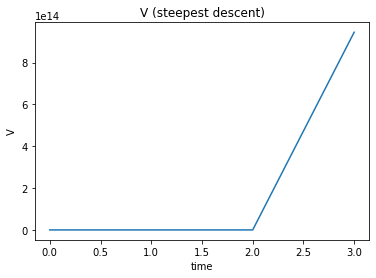

In [52]:
norm_g = np.linalg.norm(g_func(Vk))
print('||g(u)|| / ||g(u_0)||=', norm_g / norm_g0) # should be less than 1e-6

#u_including_endpoints = np.concatenate([[0], uk, [0]])

V_final = integrate_HH(Vk, m, h, n, I_stimulus, dt)

plt.figure()
plt.plot(V_final)
plt.title('V (steepest descent)')
plt.xlabel('time')
plt.ylabel('V')